In [1]:
from Selfish_RNN.sparse_rnn_core import Masking, CosineDecay
from randman_data import get_data_loaders
from LIFlayer import NHiddenModel
import torch
from tqdm import trange


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [150]:
#data generation vars 
nb_classes = 10
nb_units = 100
nb_steps = 100
nb_samples = 1000
batch_size = 100

dataloader_train, dataloader_test = get_data_loaders(nb_classes,nb_units,nb_steps,nb_samples,batch_size)

#model vars
num_hidden_layers = 2
hidden_size = 100
in_size = nb_units
out_size = nb_classes

#training vars
epochs=20

#masking vars
death_rate = .5
decay_steps = len(dataloader_train) * epochs
density = .1



In [152]:
model = NHiddenModel(num_hidden_layers,in_size,hidden_size,out_size,with_recurrent=False).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
mask = None
cos_decay = CosineDecay(death_rate,decay_steps)
mask = Masking(optimizer,death_rate_decay=cos_decay,death_rate=death_rate,growth_mode='random',redistribution_mode='none')
mask.add_module(model,density=density)
mask.init(density=density)

Removed 4 layers.
layers.0.fc_layer.weight 0
layers.1.fc_layer.weight 0
layers.2.fc_layer.weight 0
layers.3.fc_layer.weight 0
Death rate: 0.5

layers.0.fc_layer.weight 988
layers.1.fc_layer.weight 1025
layers.2.fc_layer.weight 978
layers.3.fc_layer.weight 99
Death rate: 0.5



In [144]:
(model.layers[0].fc_layer.weight.data.cpu() !=0).sum()

tensor(8967)

In [153]:
ce_loss = torch.nn.CrossEntropyLoss()
decay = .99
tepochs = trange(epochs,desc=f'accuracy')
#print((model.layers[0].fc_layer.weight.data.cpu()==0).sum())
layer_vis={}
for e in tepochs:
    print((model.layers[0].fc_layer.weight.data.cpu() !=0).sum())
    layer_vis[f'epoch_{e}_layer_0'] = model.layers[0].fc_layer.weight.data.cpu() ==0
    layer_vis[f'epoch_{e}_layer_1'] = model.layers[1].fc_layer.weight.data.cpu() ==0 
    layer_vis[f'epoch_{e}_layer_2'] = model.layers[2].fc_layer.weight.data.cpu() ==0
    mean_loss = []
    mean_acc = []
    for x,label in dataloader_train:
        model.init_states()
        Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
        x = x.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        for n in range(nb_steps):
            out_state = model(x[:,n])
            Sprobe = decay * Sprobe + out_state.S
        
        prediction = Sprobe
        accuracy = (label == prediction.argmax(axis=1)).sum()/len(prediction)
        loss = ce_loss(prediction,label)
        mean_loss.append(loss.item())
        mean_acc.append(accuracy.item())
        loss.backward()
        if mask is not None: mask.step()
        else: optimizer.step()

    #truncate and grow weights
    
    mask.at_end_of_epoch(e)

    
    
    mean_loss = sum(mean_loss)/len(dataloader_train)
    mean_acc = sum(mean_acc)/len(dataloader_train)
    tepochs.set_description(f'accuracy: {mean_acc}')
    print((model.layers[0].fc_layer.weight.data.cpu()==0).sum())
    # plt.imshow(model.layers[0].fc_layer.weight.data.cpu())
    # plt.colorbar()
    # plt.show()

            

accuracy:   0%|          | 0/20 [00:00<?, ?it/s]

tensor(988)


/Users/kerstjens/msc_thesis/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
accuracy: 0.09887499725446106:   5%|▌         | 1/20 [00:13<04:19, 13.65s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.49696356275303644
Name: layers.1.fc_layer.weight pruning_rate 0.4975609756097561
Name: layers.2.fc_layer.weight pruning_rate 0.49795501022494887
Name: layers.3.fc_layer.weight pruning_rate 0.5050505050505051
3090.0 3100.0 64.75
old, new nonzero count: 3090.0 3063 64.75
layers.0.fc_layer.weight: 988.0->926, density: 0.093, proportion: 0.2500
layers.1.fc_layer.weight: 1025.0->1052, density: 0.105, proportion: 0.2500
layers.2.fc_layer.weight: 978.0->997, density: 0.100, proportion: 0.2500
layers.3.fc_layer.weight: 99.0->88, density: 0.088, proportion: 0.2500
Death rate: 0.49695286429729674

tensor(9482)
tensor(518)


accuracy: 0.09749999728519469:  10%|█         | 2/20 [00:26<03:59, 13.30s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.48812095032397407
Name: layers.1.fc_layer.weight pruning_rate 0.48859315589353614
Name: layers.2.fc_layer.weight pruning_rate 0.4884653961885657
Name: layers.3.fc_layer.weight pruning_rate 0.48863636363636365
3063.0 3100.0 -91.5625
old, new nonzero count: 3063.0 3201 -91.5625
layers.0.fc_layer.weight: 926.0->1011, density: 0.101, proportion: 0.2500
layers.1.fc_layer.weight: 1052.0->1064, density: 0.106, proportion: 0.2500
layers.2.fc_layer.weight: 997.0->1033, density: 0.103, proportion: 0.2500
layers.3.fc_layer.weight: 88.0->93, density: 0.093, proportion: 0.2500
Death rate: 0.48788648778305094

tensor(9503)
tensor(497)


accuracy: 0.10637499778531492:  15%|█▌        | 3/20 [00:41<03:54, 13.82s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.47378832838773494
Name: layers.1.fc_layer.weight pruning_rate 0.47368421052631576
Name: layers.2.fc_layer.weight pruning_rate 0.47337850919651503
Name: layers.3.fc_layer.weight pruning_rate 0.4731182795698925
3201.0 3100.0 -33.390625
old, new nonzero count: 3201.0 3090 -33.390625
layers.0.fc_layer.weight: 1011.0->958, density: 0.096, proportion: 0.2500
layers.1.fc_layer.weight: 1064.0->1050, density: 0.105, proportion: 0.2500
layers.2.fc_layer.weight: 1033.0->981, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 93.0->101, density: 0.101, proportion: 0.2500
Death rate: 0.47302411473662154

tensor(9447)
tensor(553)


accuracy: 0.10974999689497053:  20%|██        | 4/20 [00:56<03:48, 14.26s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.453027139874739
Name: layers.1.fc_layer.weight pruning_rate 0.4533333333333333
Name: layers.2.fc_layer.weight pruning_rate 0.4536187563710499
Name: layers.3.fc_layer.weight pruning_rate 0.45544554455445546
3090.0 3100.0 27.15234375
old, new nonzero count: 3090.0 3051 27.15234375
layers.0.fc_layer.weight: 958.0->984, density: 0.098, proportion: 0.2500
layers.1.fc_layer.weight: 1050.0->988, density: 0.099, proportion: 0.2500
layers.2.fc_layer.weight: 981.0->983, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 101.0->96, density: 0.096, proportion: 0.2500
Death rate: 0.45273170610780034

tensor(9461)
tensor(539)


accuracy: 0.18974999403581022:  25%|██▌       | 5/20 [01:10<03:35, 14.34s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.42784552845528456
Name: layers.1.fc_layer.weight pruning_rate 0.42813765182186236
Name: layers.2.fc_layer.weight pruning_rate 0.42828077314343843
Name: layers.3.fc_layer.weight pruning_rate 0.4375
3051.0 3100.0 77.0380859375
old, new nonzero count: 3051.0 3025 77.0380859375
layers.0.fc_layer.weight: 984.0->952, density: 0.095, proportion: 0.2500
layers.1.fc_layer.weight: 988.0->1013, density: 0.101, proportion: 0.2500
layers.2.fc_layer.weight: 983.0->958, density: 0.096, proportion: 0.2500
layers.3.fc_layer.weight: 96.0->102, density: 0.102, proportion: 0.2500
Death rate: 0.4275089283436712

tensor(9421)
tensor(579)


accuracy: 0.28487499468028543:  30%|███       | 6/20 [01:24<03:18, 14.16s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.39810924369747897
Name: layers.1.fc_layer.weight pruning_rate 0.39881539980256664
Name: layers.2.fc_layer.weight pruning_rate 0.3987473903966597
Name: layers.3.fc_layer.weight pruning_rate 0.4019607843137255
3025.0 3100.0 -12.157145182291666
old, new nonzero count: 3025.0 3147 -12.157145182291666
layers.0.fc_layer.weight: 952.0->1024, density: 0.102, proportion: 0.2500
layers.1.fc_layer.weight: 1013.0->1032, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 958.0->981, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 102.0->110, density: 0.110, proportion: 0.2500
Death rate: 0.3979768499423878

tensor(9399)
tensor(601)


accuracy: 0.44437498934566977:  35%|███▌      | 7/20 [01:38<03:02, 14.01s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.365234375
Name: layers.1.fc_layer.weight pruning_rate 0.3653100775193798
Name: layers.2.fc_layer.weight pruning_rate 0.36493374108053006
Name: layers.3.fc_layer.weight pruning_rate 0.37272727272727274
3147.0 3100.0 56.49642799014137
old, new nonzero count: 3147.0 3037 56.49642799014137
layers.0.fc_layer.weight: 1024.0->969, density: 0.097, proportion: 0.2500
layers.1.fc_layer.weight: 1032.0->1018, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 981.0->954, density: 0.095, proportion: 0.2500
layers.3.fc_layer.weight: 110.0->96, density: 0.096, proportion: 0.2500
Death rate: 0.36486264868553825

tensor(9335)
tensor(665)


accuracy: 0.5807499896734953:  40%|████      | 8/20 [01:52<02:51, 14.26s/it] 

Name: layers.0.fc_layer.weight pruning_rate 0.32920536635706915
Name: layers.1.fc_layer.weight pruning_rate 0.3290766208251473
Name: layers.2.fc_layer.weight pruning_rate 0.32914046121593293
Name: layers.3.fc_layer.weight pruning_rate 0.3333333333333333
3037.0 3100.0 28.374106997535343
old, new nonzero count: 3037.0 3096 28.374106997535343
layers.0.fc_layer.weight: 969.0->1007, density: 0.101, proportion: 0.2500
layers.1.fc_layer.weight: 1018.0->995, density: 0.100, proportion: 0.2500
layers.2.fc_layer.weight: 954.0->1002, density: 0.100, proportion: 0.2500
layers.3.fc_layer.weight: 96.0->92, density: 0.092, proportion: 0.2500
Death rate: 0.3289817061077996

tensor(9337)
tensor(663)


accuracy: 0.6807499878108502:  45%|████▌     | 9/20 [02:08<02:42, 14.77s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.2919563058589871
Name: layers.1.fc_layer.weight pruning_rate 0.2914572864321608
Name: layers.2.fc_layer.weight pruning_rate 0.29141716566866266
Name: layers.3.fc_layer.weight pruning_rate 0.29347826086956524
3096.0 3100.0 0.7324156382727249
old, new nonzero count: 3096.0 3119 0.7324156382727249
layers.0.fc_layer.weight: 1007.0->1005, density: 0.101, proportion: 0.2500
layers.1.fc_layer.weight: 995.0->1024, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 1002.0->979, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 92.0->111, density: 0.111, proportion: 0.2500
Death rate: 0.2912175300974572

tensor(9268)
tensor(732)


accuracy: 0.7698749810457229:  50%|█████     | 10/20 [02:20<02:19, 13.91s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.2527363184079602
Name: layers.1.fc_layer.weight pruning_rate 0.2529296875
Name: layers.2.fc_layer.weight pruning_rate 0.2533197139938713
Name: layers.3.fc_layer.weight pruning_rate 0.26126126126126126
3119.0 3100.0 9.833103909568182
old, new nonzero count: 3119.0 3097 9.833103909568182
layers.0.fc_layer.weight: 1005.0->1013, density: 0.101, proportion: 0.2500
layers.1.fc_layer.weight: 1024.0->1015, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 979.0->972, density: 0.097, proportion: 0.2500
layers.3.fc_layer.weight: 111.0->97, density: 0.097, proportion: 0.2500
Death rate: 0.2525

tensor(9241)
tensor(759)


accuracy: 0.8576249837875366:  55%|█████▌    | 11/20 [02:33<02:01, 13.51s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.21421520236920039
Name: layers.1.fc_layer.weight pruning_rate 0.21379310344827587
Name: layers.2.fc_layer.weight pruning_rate 0.2139917695473251
Name: layers.3.fc_layer.weight pruning_rate 0.21649484536082475
3097.0 3100.0 2.4582759773920455
old, new nonzero count: 3097.0 3108 2.4582759773920455
layers.0.fc_layer.weight: 1013.0->995, density: 0.100, proportion: 0.2500
layers.1.fc_layer.weight: 1015.0->1035, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 972.0->978, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 97.0->100, density: 0.100, proportion: 0.2500
Death rate: 0.2137824699025428

tensor(9199)
tensor(801)


accuracy: 0.9062499821186065:  60%|██████    | 12/20 [02:49<01:54, 14.29s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.17688442211055277
Name: layers.1.fc_layer.weight pruning_rate 0.17681159420289855
Name: layers.2.fc_layer.weight pruning_rate 0.1768916155419223
Name: layers.3.fc_layer.weight pruning_rate 0.18
3108.0 3100.0 -10.552097672318654
old, new nonzero count: 3108.0 3120 -10.552097672318654
layers.0.fc_layer.weight: 995.0->990, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1035.0->1040, density: 0.104, proportion: 0.2500
layers.2.fc_layer.weight: 978.0->992, density: 0.099, proportion: 0.2500
layers.3.fc_layer.weight: 100.0->98, density: 0.098, proportion: 0.2500
Death rate: 0.1760182938922006

tensor(9178)
tensor(822)


accuracy: 0.9279999822378159:  65%|██████▌   | 13/20 [03:08<01:49, 15.63s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.1404040404040404
Name: layers.1.fc_layer.weight pruning_rate 0.14038461538461539
Name: layers.2.fc_layer.weight pruning_rate 0.14112903225806453
Name: layers.3.fc_layer.weight pruning_rate 0.14285714285714285
3120.0 3100.0 31.49659096653572
old, new nonzero count: 3120.0 3063 31.49659096653572
layers.0.fc_layer.weight: 990.0->985, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1040.0->1022, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 992.0->959, density: 0.096, proportion: 0.2500
layers.3.fc_layer.weight: 98.0->97, density: 0.097, proportion: 0.2500
Death rate: 0.14013735131446217

tensor(9148)
tensor(852)


accuracy: 0.9456249803304673:  70%|███████   | 14/20 [03:25<01:37, 16.26s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.10761421319796954
Name: layers.1.fc_layer.weight pruning_rate 0.10763209393346379
Name: layers.2.fc_layer.weight pruning_rate 0.10740354535974973
Name: layers.3.fc_layer.weight pruning_rate 0.1134020618556701
3063.0 3100.0 17.088433455919645
old, new nonzero count: 3063.0 3096 17.088433455919645
layers.0.fc_layer.weight: 985.0->984, density: 0.098, proportion: 0.2500
layers.1.fc_layer.weight: 1022.0->1024, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 959.0->979, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 97.0->109, density: 0.109, proportion: 0.2500
Death rate: 0.10702315005761286

tensor(9120)
tensor(880)


accuracy: 0.9536249816417695:  75%|███████▌  | 15/20 [03:40<01:18, 15.68s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.0782520325203252
Name: layers.1.fc_layer.weight pruning_rate 0.078125
Name: layers.2.fc_layer.weight pruning_rate 0.07763023493360573
Name: layers.3.fc_layer.weight pruning_rate 0.09174311926605505
3096.0 3100.0 23.138775030646578
old, new nonzero count: 3096.0 3084 23.138775030646578
layers.0.fc_layer.weight: 984.0->987, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1024.0->1026, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 979.0->972, density: 0.097, proportion: 0.2500
layers.3.fc_layer.weight: 109.0->99, density: 0.099, proportion: 0.2500
Death rate: 0.07749107165632947

tensor(9093)
tensor(907)


accuracy: 0.9641249723732471:  80%|████████  | 16/20 [03:55<01:02, 15.61s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.05268490374873354
Name: layers.1.fc_layer.weight pruning_rate 0.05263157894736842
Name: layers.2.fc_layer.weight pruning_rate 0.05246913580246913
Name: layers.3.fc_layer.weight pruning_rate 0.06060606060606061
3084.0 3100.0 23.597193757661643
old, new nonzero count: 3084.0 3086 23.597193757661643
layers.0.fc_layer.weight: 987.0->994, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1026.0->1029, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 972.0->962, density: 0.096, proportion: 0.2500
layers.3.fc_layer.weight: 99.0->101, density: 0.101, proportion: 0.2500
Death rate: 0.05226829389220058

tensor(9065)
tensor(935)


accuracy: 0.9703749708831311:  85%|████████▌ | 17/20 [04:09<00:45, 15.21s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.03219315895372234
Name: layers.1.fc_layer.weight pruning_rate 0.03206997084548105
Name: layers.2.fc_layer.weight pruning_rate 0.032224532224532226
Name: layers.3.fc_layer.weight pruning_rate 0.039603960396039604
3086.0 3100.0 21.678710204121295
old, new nonzero count: 3086.0 3089 21.678710204121295
layers.0.fc_layer.weight: 994.0->999, density: 0.100, proportion: 0.2500
layers.1.fc_layer.weight: 1029.0->1022, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 962.0->970, density: 0.097, proportion: 0.2500
layers.3.fc_layer.weight: 101.0->98, density: 0.098, proportion: 0.2500
Death rate: 0.03197588526337896

tensor(9038)
tensor(962)


accuracy: 0.9738749712705612:  90%|█████████ | 18/20 [04:23<00:29, 14.85s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.018018018018018018
Name: layers.1.fc_layer.weight pruning_rate 0.01761252446183953
Name: layers.2.fc_layer.weight pruning_rate 0.01752577319587629
Name: layers.3.fc_layer.weight pruning_rate 0.02040816326530612
3089.0 3100.0 4.475233106585879
old, new nonzero count: 3089.0 3110 4.475233106585879
layers.0.fc_layer.weight: 999.0->991, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1022.0->1027, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 970.0->987, density: 0.099, proportion: 0.2500
layers.3.fc_layer.weight: 98.0->105, density: 0.105, proportion: 0.2500
Death rate: 0.017113512216949477

tensor(9019)
tensor(981)


accuracy: 0.9824999667704105:  95%|█████████▌| 19/20 [04:38<00:14, 14.85s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.008072653884964682
Name: layers.1.fc_layer.weight pruning_rate 0.008763388510223954
Name: layers.2.fc_layer.weight pruning_rate 0.008105369807497468
Name: layers.3.fc_layer.weight pruning_rate 0.047619047619047616
3110.0 3100.0 12.145124066120154
old, new nonzero count: 3110.0 3094 12.145124066120154
layers.0.fc_layer.weight: 991.0->989, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1027.0->1026, density: 0.103, proportion: 0.2500
layers.2.fc_layer.weight: 987.0->979, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 105.0->100, density: 0.100, proportion: 0.2500
Death rate: 0.008047135702703411

tensor(9017)
tensor(983)


accuracy: 0.9844999708235264: 100%|██████████| 20/20 [04:53<00:00, 14.69s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.005055611729019211
Name: layers.1.fc_layer.weight pruning_rate 0.005847953216374269
Name: layers.2.fc_layer.weight pruning_rate 0.005107252298263534
Name: layers.3.fc_layer.weight pruning_rate 0.01
3094.0 3100.0 18.03628101653004
old, new nonzero count: 3094.0 3089 18.03628101653004
layers.0.fc_layer.weight: 989.0->989, density: 0.099, proportion: 0.2500
layers.1.fc_layer.weight: 1026.0->1023, density: 0.102, proportion: 0.2500
layers.2.fc_layer.weight: 979.0->978, density: 0.098, proportion: 0.2500
layers.3.fc_layer.weight: 100.0->99, density: 0.099, proportion: 0.2500
Death rate: 0.005

tensor(9016)


In [82]:
layer_vis

{'epoch_0_layer_0': tensor([[ True, False, False,  True, False],
         [False,  True, False, False, False],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True, False, False],
         [ True, False,  True,  True,  True]]),
 'epoch_0_layer_1': tensor([[False,  True, False, False, False],
         [ True, False, False,  True,  True],
         [False,  True, False,  True, False],
         [False,  True,  True, False,  True],
         [ True,  True,  True, False,  True]]),
 'epoch_0_layer_2': tensor([[False,  True, False,  True,  True],
         [False,  True,  True, False,  True],
         [ True, False,  True,  True, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True, False,  True]]),
 'epoch_1_layer_0': tensor([[ True, False,  True,  True,  True],
         [False,  True, False, False, False],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True, False, False],
         [ True, False,  True,  True,  True]

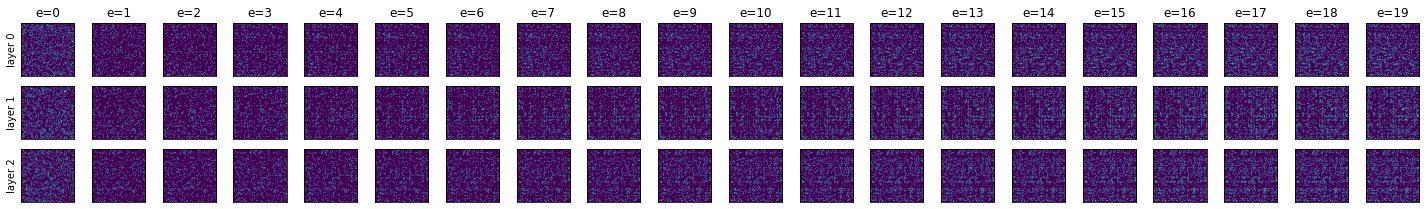

In [165]:
import numpy as np
fig, ax = plt.subplots(3,20,figsize=(20,3))
epochs=20
layers=3

for layer in range(layers):   
    for e in range(epochs):
        
        ax[layer,e].imshow(torch.logical_not(layer_vis[f'epoch_{e}_layer_{layer}']))
        ax[layer,e].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

        if layer == 0:
            ax[layer,e].set_title(f'e={e}')
        if e == 0:
            ax[layer,e].set_ylabel(f'layer {layer}')
            

fig.tight_layout()

plt.show()
#ax[0].imshow(model.layers[0].fc_layer.weight.data.cpu()==0)
#ax[1].imshow(model.layers[1].fc_layer.weight.data.cpu()==0)
#im = ax[2].imshow(model.layers[2].fc_layer.weight.data.cpu()==0)


In [164]:
layer_vis['epoch_0_layer_0']

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [83]:
layer_vis[f'epoch_{e}_layer_{layer}']

tensor([[ True,  True, False,  True,  True],
        [False,  True,  True, False,  True],
        [ True, False,  True,  True,  True],
        [ True,  True,  True, False, False],
        [False,  True,  True,  True, False]])

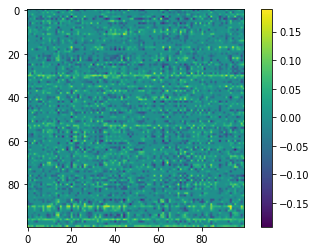

In [27]:
import matplotlib.pyplot as plt

plt.imshow(model.layers[0].fc_layer.weight.data.cpu())
plt.colorbar()

tensor(0., device='cuda:0')